### Применение  нейронной сети LSTM

In [2]:
!pip install keras >> null

In [3]:
!pip install tensorflow >> null

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras
from keras.layers import  GRU
from tensorflow.keras.layers import Layer, MultiHeadAttention, LSTMCell, Dense, LayerNormalization
import tensorflow as tf

import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('dataset2.csv', header=0, infer_datetime_format=True,
                   parse_dates=['course_finished_date'], index_col=['course_finished_date'])

/var/folders/4d/01h37whs1gsddkj2yj7jszjh0000gn/T/ipykernel_3062/3093744513.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('dataset2.csv', header=0, infer_datetime_format=True,


In [6]:
# Выбор целевой переменной и масштабирование данных
scaler = MinMaxScaler()
df['course_duration_scaled'] = scaler.fit_transform(df[['course_duration_sum']])

In [7]:
# Создание последовательности временных рядов
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length])
    return np.array(X), np.array(y)


In [8]:
# Определение параметров модели
sequence_length = 10  # Длина последовательности (количество предыдущих точек данных, используемых для прогнозирования следующей)
n_features = 1  # Количество признаков (в нашем случае это продолжительность курса)


In [9]:
# Создание последовательностей для обучения
X, y = create_sequences(df['course_duration_scaled'], sequence_length)


In [10]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test = X[:365], X[365:-30]
y_train, y_test = y[:365], y[365:-30]

In [11]:
class xLSTM(Layer):
    def __init__(self, units, mem_slots=100, num_heads=4, return_sequences=False, **kwargs):
        super(xLSTM, self).__init__(**kwargs)
        self.units = units
        self.mem_slots = mem_slots
        self.num_heads = num_heads
        self.return_sequences = return_sequences
        
    def build(self, input_shape):
        # Проверка входной формы
        if len(input_shape) != 3:
            raise ValueError(f"Input shape must be 3D, got {input_shape}")
            
        self.lstm_cell = LSTMCell(self.units)
        self.memory = self.add_weight(
            name='memory',
            shape=(self.mem_slots, self.units),
            initializer='glorot_uniform',
            trainable=True)
            
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.units)
            
        self.trend_projection = Dense(self.units, activation='tanh')
        self.layer_norm = LayerNormalization()
        
        super(xLSTM, self).build(input_shape)
        
    def call(self, inputs):
        # Явная проверка формы входных данных
        if len(inputs.shape) != 3:
            raise ValueError(f"Input tensor must be 3D, got shape {inputs.shape}")
            
        batch_size = tf.shape(inputs)[0]
        time_steps = inputs.shape[1]
        features = inputs.shape[2]
        
        # Инициализация состояний
        h_state = self.trend_projection(inputs[:, -1, :])  # Используем последний временной шаг
        c_state = tf.zeros((batch_size, self.units))
        
        outputs = []
        for t in range(time_steps):
            # Получаем текущий временной шаг
            x = inputs[:, t, :]
            
            # LSTM шаг
            new_h, [_, new_c] = self.lstm_cell(x, [h_state, c_state])
            
            # Residual connection
            h_state = self.layer_norm(h_state + new_h)
            c_state = new_c
            
            # Механизм внимания
            query = tf.expand_dims(h_state, 1)
            memory = tf.expand_dims(self.memory, 0)
            memory = tf.tile(memory, [batch_size, 1, 1])
            
            # Модуляция памяти трендом
            trend = tf.linspace(0., 1., self.mem_slots)
            trend = tf.reshape(trend, (1, -1, 1))
            modulated_memory = memory * (1. + 0.1 * trend)
            
            attention_out = self.attention(query, modulated_memory, modulated_memory)
            
            # Комбинируем выходы
            combined = tf.concat([h_state, tf.squeeze(attention_out, axis=1)], axis=-1)
            outputs.append(combined)
        
        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        return outputs[-1]
    
    def compute_output_shape(self, input_shape):
        if self.return_sequences:
            return (input_shape[0], input_shape[1], self.units * 2)
        return (input_shape[0], self.units * 2)
    
    def get_config(self):
        config = super(xLSTM, self).get_config()
        config.update({
            'units': self.units,
            'mem_slots': self.mem_slots,
            'num_heads': self.num_heads,
            'return_sequences': self.return_sequences
        })
        return config

In [12]:
# Построение модели xLSTM
model = Sequential([
    xLSTM(128, mem_slots=50, num_heads=4, 
                input_shape=(sequence_length, n_features),
                return_sequences=True),  # Первый слой возвращает последовательность
    Dropout(0.3),
    xLSTM(64, mem_slots=50, num_heads=4,
                return_sequences=False),  # Последний слой - только финальный выход
    Dropout(0.2),
    Dense(32, activation='swish'),
    Dense(1)  # Одно предсказание
])

model.compile(optimizer='adam', loss='huber')

/var/folders/4d/01h37whs1gsddkj2yj7jszjh0000gn/T/ipykernel_3062/197920355.py:6: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(EnhancedxLSTM, self).__init__(**kwargs)


In [13]:
# Остановка обучения, если нет улучшений
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)


In [14]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=100, batch_size=13, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.1147 - val_loss: 8.7983e-04
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0043 - val_loss: 7.4419e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0026 - val_loss: 0.0023


In [15]:
# Оценка модели
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.0505e-04
Test Loss: 0.0011224549962207675


In [16]:
# Прогнозирование на тестовом наборе данных
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


In [17]:
# Инвертирование масштабирования
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [18]:
# Оценка качества модели
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('RMSE:', mse**0.5)

RMSE: 206.27328745173364


In [19]:
# преобразование датасета для построения графика
y_test_n = [el[0] for el in y_test_inv]
y_pred_n = [el[0] for el in y_pred_inv]
result_df = pd.DataFrame()
result_df["test"] = y_test_n
result_df["pred"] = y_pred_n
result_df.index = df.index[375:-30]

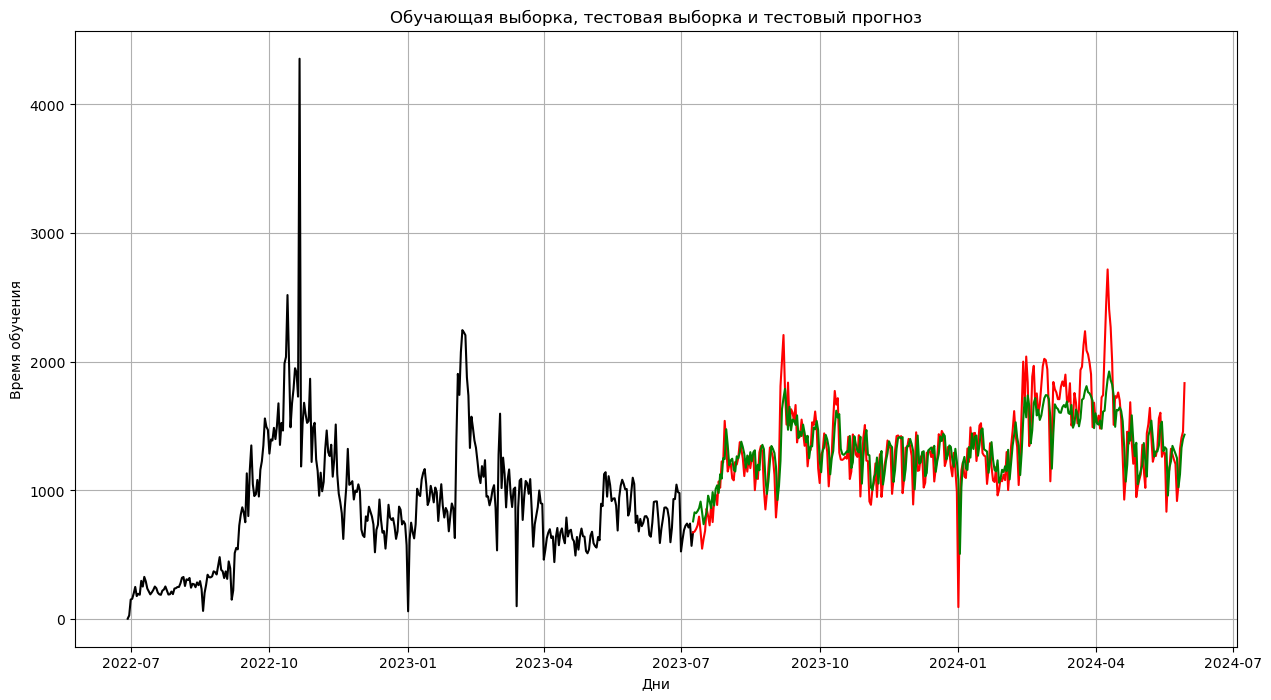

In [20]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(15,8))
plt.plot(df['course_duration_sum'][:365+11], color = "black")
plt.plot(result_df["test"], color = "red")
plt.plot(result_df["pred"], color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

Оценка качества модели на отрезке в 7 дней

In [22]:
X_train, X_test = X[:-37], X[-37:-30]
y_train, y_test = y[:-37], y[-37:-30]
model = Sequential()

model = Sequential([
    xLSTM(128, mem_slots=50, num_heads=4, 
                input_shape=(sequence_length, n_features),
                return_sequences=True),  # Первый слой возвращает последовательность
    Dropout(0.3),
    xLSTM(64, mem_slots=50, num_heads=4,
                return_sequences=False),  # Последний слой - только финальный выход
    Dropout(0.2),
    Dense(32, activation='swish'),
    Dense(1)  # Одно предсказание
])
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=13, callbacks=[early_stopping])

y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
print('RMSE:', mse**0.5)

Epoch 1/100


/var/folders/4d/01h37whs1gsddkj2yj7jszjh0000gn/T/ipykernel_3062/197920355.py:6: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(EnhancedxLSTM, self).__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.1743
Epoch 2/100
 3/53 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0222

/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0178
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0127
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0070
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0068
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0057
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0062
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0052
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0049
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0038
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0059
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0049
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0048
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0036
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0033
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0046


In [23]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('RMSE:', mse**0.5)

RMSE: 220.35333643001502
